# NPCC Contingency Analysis

Reference:

1. Zhang, Q., Li, F. A Dataset for Electricity Market Studies on Western and Northeastern Power Grids in the United States. Sci Data 10, 646 (2023). https://doi.org/10.1038/s41597-023-02448-w
1. https://github.com/enliten/ENLITEN-Grid-Econ-Data/

In [1]:
from tqdm import tqdm

import numpy as np
import pandas as pd

import andes
import ams

import datetime

import matplotlib
import matplotlib.pyplot as plt

In [2]:
matplotlib.rcdefaults()

In [3]:
%matplotlib inline

In [4]:
print("Last run time:", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

print(f'andes:{andes.__version__}')
print(f'ams:{ams.__version__}')

Last run time: 2024-04-07 16:24:23
andes:1.9.1.post29+gdf5dc682
ams:0.9.5.post25+g738d558


In [5]:
andes.config_logger(stream_level=20)
ams.config_logger(stream_level=20)

In [6]:
ams_file = './data/npcc_uced_base.xlsx'
andes_file = './data/npcc_ibr.xlsx'
out_file = './data/npcc_base_ll_out.csv'

In [7]:
sp = ams.load(ams_file,
              setup=True,
              no_output=True,
              default_config=True,)

Working directory: "/Users/jinningwang/Documents/work/psal/src/notes/lmp"
Parsing input file "./data/npcc_uced_base.xlsx"...
Input file parsed in 0.2359 seconds.
Zero line rates detacted in rate_b, rate_c, adjusted to 999.
System set up in 0.0031 seconds.


In [8]:
idx_pq = sp.PQ.idx.v
p0_pq = sp.PQ.p0.v.copy()
q0_pq = sp.PQ.q0.v.copy()
# 0.95, 1.1
k_load = 0.95 # load factor
sp.PQ.alter(src='p0', idx=idx_pq, value=p0_pq * k_load)
sp.PQ.alter(src='q0', idx=idx_pq, value=q0_pq * k_load)

In [9]:
sa = sp.to_andes(addfile=andes_file,
                 setup=True, no_output=True, default_config=True)

tg_idx = sa.TGOV1NDB.idx.v
sa.TGOV1NDB.set(src='VMAX', attr='v', idx=tg_idx,
                value=999*np.ones(sa.TGOV1NDB.n))
sa.TGOV1NDB.set(src='VMIN', attr='v', idx=tg_idx,
                value=-999*np.ones(sa.TGOV1NDB.n))

iex_idx = sa.IEEEX1.idx.v
sa.IEEEX1.set(src='VRMAX', attr='v', idx=iex_idx,
              value=200*np.ones(sa.IEEEX1.n))
sa.IEEEX1.set(src='VRMIN', attr='v', idx=iex_idx,
              value=-200*np.ones(sa.IEEEX1.n))

> Loaded generated Python code in "/Users/jinningwang/.andes/pycode".
Parsing additional file "./data/npcc_ibr.xlsx"...
Following PFlow models in addfile will be overwritten: <Bus>, <PQ>, <PV>, <Slack>, <Line>, <Area>
Addfile parsed in 0.2081 seconds.
System converted to ANDES in 0.1817 seconds.
AMS system 0x1043f1d00 is linked to the ANDES system 0x17fc6c9d0.
System internal structure set up in 0.0266 seconds.
<PFlow> initialized in 0.0073 seconds.
 0: |F(x)| = 1.224418366
 1: |F(x)| = 0.8013335527
 2: |F(x)| = 0.009184784714
 3: |F(x)| = 2.006025558e-06
 4: |F(x)| = 2.924327447e-13
<PFlow> solved in 0.0267 seconds, converged in 4 iterations with PYPOWER-Newton.
-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: Off
   Sparse solver: KLU
 Solution method: NR method
Power flow initialized in 0.0051 seconds.
0: |F(x)| = 1.962306492
1: |F(x)

True

In [10]:
vsg_idx = sa.REGCV1.gen.v
gcost_vsg_idx = sp.GCost.find_idx(keys='gen', values=vsg_idx)
sp.GCost.set(src='c2', attr='v', idx=gcost_vsg_idx, value=np.zeros(sa.REGCV1.n))
sp.GCost.set(src='c1', attr='v', idx=gcost_vsg_idx, value=np.zeros(sa.REGCV1.n))
sp.GCost.set(src='c0', attr='v', idx=gcost_vsg_idx, value=np.zeros(sa.REGCV1.n))

True

In [11]:
sp.RTED.init()

sp.RTED.run(solver='MOSEK')

sp.RTED.dc2ac()

sp.dyn.send(routine='RTED', adsys=sa)

<RTED> initialized in 0.0223 seconds.
<RTED> solved as optimal in 0.0477 seconds, converged in 13 iterations with MOSEK.
<ACOPF> initialized in 0.0051 seconds.
<ACOPF> solved in 0.8167 seconds, converged in 26 iterations with PYPOWER-PIPS.
<RTED> converted to AC.
Send <RTED> results to ANDES <0x17fc6c9d0>...
*Send <vBus> to StaticGen.v0
Send <vBus> to Bus.v0
Send <ug> to StaticGen.u
Send <pg> to StaticGen.p0


True

In [12]:
sa.PFlow.run()

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: Off
   Sparse solver: KLU
 Solution method: NR method
Power flow initialized in 0.0037 seconds.
0: |F(x)| = 19.76704881
1: |F(x)| = 5.372863258
2: |F(x)| = 0.5127978917
3: |F(x)| = 0.007964777809
4: |F(x)| = 5.773475845e-06
5: |F(x)| = 4.806821607e-12
Converged in 6 iterations in 0.0162 seconds.


True

In [13]:
_ = sa.TDS.init()

GENROU (vf range) out of typical lower limit.

   idx     | values | limit
-----------+--------+------
 GENROU_61 | 0.881  | 1    


GENROU (vf range) out of typical upper limit.

   idx     | values | limit
-----------+--------+------
 GENROU_27 | 5.039  | 5    
 GENROU_56 | 7.144  | 5    


Initialization for dynamics completed in 0.0448 seconds.
Initialization was successful.


In [14]:
sa.TDS.config.criteria = False
sa.TDS.config.no_tqdm = False

sa.TDS.config.tf = 50
sa.TDS.run()


-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-50 s.
Fixed step size: h=33.33 ms. Shrink if not converged.


  0%|          | 0/100 [00:00<?, ?%/s]

<Toggle Toggler_1>: SynGen.GENROU_98 status changed to 0 at t=1.0 sec.


Simulation to t=50.00 sec completed in 3.4669 seconds.


True

(<Figure size 1500x450 with 2 Axes>, <Axes: xlabel='Time [s]'>)

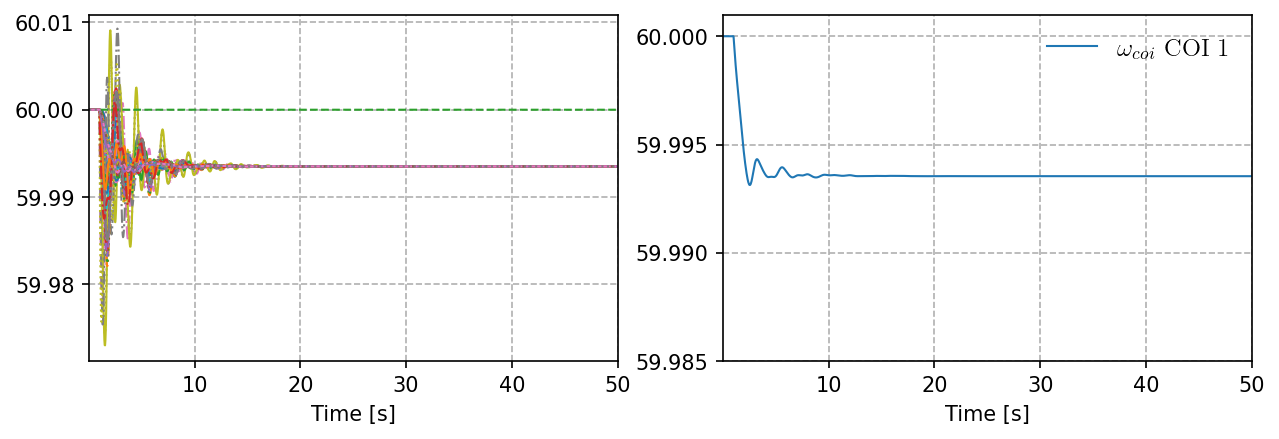

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), dpi=150)

sa.TDS.plt.plot(sa.GENCLS.omega,
                ytimes=sa.config.freq,
                ax=ax[0], fig=fig,
                grid=True, show=False,
                legend=False,
                # ymin=59.7, ymax=60.06,
                )
sa.TDS.plt.plot(sa.GENROU.omega,
                ytimes=sa.config.freq,
                ax=ax[0], fig=fig,
                grid=True, show=False,
                legend=False,
                # ymin=59.7, ymax=60.06,
                )
sa.TDS.plt.plot(sa.REGCV1.omega,
                ytimes=sa.config.freq,
                ax=ax[0], fig=fig,
                grid=True, show=False,
                legend=False,
                # ymin=59.7, ymax=60.06,
                )

sa.TDS.plt.plot(sa.COI.omega,
                ytimes=sa.config.freq,
                ax=ax[1], fig=fig,
                grid=True, show=False,
                ymin=59.985, ymax=60.001,
                )

In [16]:
# sa.TDS.plt.export_csv(out_file)